In [225]:
import random
import string
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import math

from matplotlib.patches import Rectangle  

class WorldNode:
    
    def __init__(self, name):
        self.id = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(8))
        self.people = {}
        self.name = name
        
    def run_infection(self):
        ''' Give everyone in the room a chance to get sick. Each sick person has
            a level of contagiousness which represents the probability of them
            infecting a person that comes near them. The contagiousness should be
            some function of the time that the person has been sick (maybe 1/n or such).
            
            We model the probability of a person being infected as the union of interactions
            with sick people in the room as follows: '''
        threat = 0
        for k in self.people:
            if self.people[k].infected:
                threat += self.people[k].get_contagiousness()
        # Use logistic function to clamp the probability between 0 and 1
        threat = 1.0 / (1 + math.exp(-threat)) - 0.5   
        for k in self.people:
            if not self.people[k].infected:
                if random.random() < threat:
                    self.people[k].infect()
                    
    def add_person(self, p):
        self.people[p.name] = p
        
    def remove_person(self, p):
        del self.people[p.name]
                                                
class Person:
    
    ''' The actual person class would probably include other things like a probability distribution of where they go
        from each node. '''
    
    def __init__(self, schedule):
        # Number of people infected is determined by this. To get a proportion of the population to
        # be infected, use self.infected = random.random() < x, where x is e.g. 0.05 for 5% of the population
        self.infected = random.random() < .05
        # How infectious the diease is
        self.contagiousness = max(random.random(), 0.1) if self.infected else 0
        self.name = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(8))
        self.fixed_nodes = {}
        self.other_nodes = {}
        self.schedule = schedule
        self.current_node = None
        
    def get_scheduled_node(self, t):
        ''' If there is a scheduled place to be at this time, return it, otherwise return None.'''
        for (start, end, name) in self.schedule:
            if t >= start and t < end:
                return self.fixed_nodes[name]
        
    def add_node(self, node, fixed_name=None):
        if fixed_name == "Home":
            self.move_to_node(node)
            
        if fixed_name != None:
            self.fixed_nodes[fixed_name] = node
        else:
            self.other_nodes[node.name] = node
            
    def randomize_nodes(self):
        probs = [random.random() for _ in range(len(self.other_nodes))]
        total = sum(probs)
        while total > 1.0:
            probs = [p * 0.95 for p in probs]
            total = sum(probs)
        x = 1.0 - total
        probs[len(probs)-1] += x
        self.other_node_probs = probs
        
    def infect(self):
        self.infected = True
        
    def set_rate(self):
        self.contagiousness = rate
        
    def get_contagiousness(self):
        return self.contagiousness
        
    def cure(self):
        self.infected = False
        
    def choose_next_node(self):
        ''' Pick a random node that is not one of the fixed ones (school etc) '''
        cumulative_prob = 0
        r = random.random()
        for name, prob in zip(list(self.other_nodes.keys()), self.other_node_probs):
            cumulative_prob += prob
            if r < cumulative_prob:
                return self.other_nodes[name]
        raise Exception("Could not choose next node")
        
    def move_to_node(self, node):
        if self.current_node != None:
            self.current_node.remove_person(self)
        self.current_node = node
        self.current_node.add_person(self)

def create_person(homes, workplaces, schools, other, schedule, num_nodes):
    p = Person(schedule)
    p.add_node(random.choice(homes), fixed_name="Home")
    p.add_node(random.choice(workplaces), fixed_name="Work")
    p.add_node(random.choice(schools), fixed_name="School")
    for node in random.sample(other, num_nodes - 3):
        p.add_node(node)
    p.randomize_nodes()
    return p

def make_nodes(names):
    return [WorldNode(name) for name in names]



def visualize_world(all_nodes, fig=plt):
    # Build a grid that looks like
    # [1][2][3]
    # [4][5][6]
    # [7][8][9]
    n = math.ceil(math.sqrt(len(all_nodes)))
    cell_side = 0.8 # Cell side length
    # n by n grid
    # Assign nodes to squares
    nodes = {}
    for i, node in enumerate(all_nodes):
        nodes[i] = node
    def index_to_xy(i):
        return(i % n, int(i/n))
    
    xs = []
    ys = []
    
    for k in nodes:
        node = nodes[k]
        x, y = index_to_xy(k)
        for person in node.people.values():
            px = x + random.random()*cell_side
            py = y + random.random()*cell_side
            color = 'red' if person.infected else 'blue'
            plt.scatter([px], [py], color=color)
            xs.append(px)
            ys.append(py)
        currentAxis = fig.gca()
        currentAxis.add_patch(Rectangle((x, y), 1*cell_side, 1*cell_side, facecolor="none"))
        
    plt.axes().set_aspect('equal', 'datalim')
    plt.axis('off')
    plt.show()

from IPython.display import display, clear_output
# Pass in the number of iterations to do and the number of people
def visualize_simulation(iters, num_people):
    
    def make_nodes(names):
        return [WorldNode(name) for name in names]
    
    times = []
    infected_nums = []
    
    homes = make_nodes(list(set([("Home %d") % i for i in range(10)])))
    workplaces = make_nodes(list(set([("Work %d") % i for i in range(10)])))
    schools = make_nodes(list(set([("School %d") % i for i in range(10)])))
    
    other_types = ["Hobby", "Restaurant"]
    other = make_nodes(list(set([("%s %d") % (random.choice(other_types), i) for i in range(10)])))
    
    schedules = [[(0, 8, "Home"), (8, 15, "School"), (17, 21, "Work"), (23, 24, "Home")], \
                 [(0, 8, "Home"), (8, 15, "School"), (23, 24, "Home")]]

    people = [create_person(homes, workplaces, schools, other, random.choice(schedules), random.randint(6, 10)) for _ in range(num_people)]
    all_nodes = homes + workplaces + schools + other
    
    fig, ax = plt.subplots(figsize =(10,10))
    
    for i in range(iters):
        time = i % 24
        times.append(time)
        infected_nums.append(sum([int(p.infected) for p in people]))
        ''' Move people if they should move '''
        for p in people:
            n = p.get_scheduled_node(time)
            if n == None:
                n = p.choose_next_node()
            if n.name != p.current_node.name:
                p.move_to_node(n)
        for n in all_nodes:
            n.run_infection()
        clear_output(wait=True)
        display(fig)
        fig.clear()
        visualize_world(all_nodes, fig=fig)

    
# Pass in the number of iterations to do and the number of people
def run_simulation(iters, num_people):
    
    def make_nodes(names):
        return [WorldNode(name) for name in names]
    
    times = []
    infected_nums = []
    
    homes = make_nodes(list(set([("Home %d") % i for i in range(10)])))
    workplaces = make_nodes(list(set([("Work %d") % i for i in range(10)])))
    schools = make_nodes(list(set([("School %d") % i for i in range(10)])))
    
    other_types = ["Hobby", "Restaurant"]
    other = make_nodes(list(set([("%s %d") % (random.choice(other_types), i) for i in range(10)])))
    
    schedules = [[(0, 8, "Home"), (8, 15, "School"), (17, 21, "Work"), (23, 24, "Home")], \
                 [(0, 8, "Home"), (8, 15, "School"), (23, 24, "Home")]]

    people = [create_person(homes, workplaces, schools, other, random.choice(schedules), random.randint(6, 10)) for _ in range(num_people)]
    all_nodes = homes + workplaces + schools + other
        
    for i in range(iters):
        time = i % 24
        times.append(time)
        infected_nums.append(sum([int(p.infected) for p in people]))
        ''' Move people if they should move '''
        for p in people:
            n = p.get_scheduled_node(time)
            if n == None:
                n = p.choose_next_node()
            if n.name != p.current_node.name:
                p.move_to_node(n)
        for n in all_nodes:
            n.run_infection()
    
    return (people, all_nodes, times, infected_nums)

### The following code runs n number of iterations for m number of people through our model.

In [226]:
_,_,a,b = run_simulation(1000,100) #'''iters num people'''

In [230]:
a = np.asarray(a)
b = np.asarray(b)
#print(b)

In [228]:
times = np.linspace(0,len(b)+1,len(b))

### A simoid is then fitted to the data so the constant K can be determined to see at what sorts of rates people are being infected.

[  8.56988351e-03   1.49628346e+02]


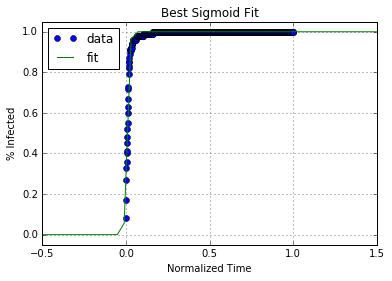

In [229]:
import numpy as np
import pylab
from scipy.optimize import curve_fit
%matplotlib inline
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

xdata = times/(max(times))#np.array([0.0,   1.0,  3.0, 4.3, 7.0,   8.0,   8.5, 10.0, 12.0]) #time/max(time) 
ydata = b/max(b) #np.array([0.01, 0.02, 0.04, 0.11, 0.43,  0.7, 0.89, 0.95, 0.99]) #symptom_array/max(symptom_array) 

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)

x = np.linspace(-.5, 1.5, 50)
y = sigmoid(x, *popt)
#y2 = sigmoid(x,.07072579,8.74293457)
pylab.plot(xdata, ydata,'o', label='data')
pylab.plot(x,y, label='fit')
#pylab.plot(x,y2, label='example')
pylab.ylim(-.05, 1.05)
pylab.legend(loc='best')
pylab.title('Best Sigmoid Fit')
pylab.xlabel('Normalized Time')
pylab.ylabel('% Infected')
pylab.grid(True)

Population   | Infection Population | Infection Rate 
------------ | -------------- | -------------
10| 5% |~ .8
25| 5%| ~ 1
50| 5%|~15
100| 5%|~40
200|5%|~112
500|5%|~363
10| 10% |~ 2
25| 10%| ~12
50| 10%|~ 41
100| 10%|~120
200|10%|~232
500|10%|~818
10| 25% |~9
25| 25%| ~50
50| 25%|~158
100| 25%|~333
200|25%|~739
500|25%|~1220

Population   | Infection Population | Infection Rate 
------------ | -------------- | -------------
10| 50% |~ 60
25| 50%| ~138
50| 50%|~300
100| 50%|~623
200|50%|~917
500|50%|~964
10| 75% |~51
25| 75%| ~230
50| 75%|~442
100| 75%|~700
200|75%|~796
500|75%|~815

In [234]:
average = 0
for i in range(10):
    _,_,a,b = run_simulation(1000,100) #'''iters num people'''
    a = np.asarray(a)
    b = np.asarray(b)
    times = np.linspace(0,len(b)+1,len(b))
    xdata = times/(max(times))
    ydata = b/max(b) 

    popt, pcov = curve_fit(sigmoid, xdata, ydata)
    average += popt[1]
print(average/10)

#(Run1 + Run2 + Run3 + Run4 + Run5)/5

39.3361860298


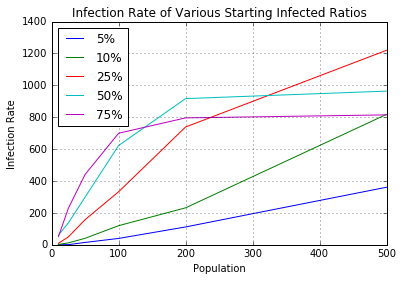

In [235]:
x = [10,25,50,100,200,500]
i5 = [.8,1,15,40,112,361]
i10 = [2,12,41,120,232,818]
i25 = [9,50,158,333,739,1220]
i50 = [60,138,300,623,917,964]
i75 = [51,230,442,700,796,815]
plt.plot(x,i5,label = '5%')
plt.plot(x,i10, label = '10%')
plt.plot(x,i25, label = '25%')
plt.plot(x,i50, label = '50%')
plt.plot(x,i75, label = '75%')
plt.legend(loc = 'upper left')
plt.title('Infection Rate of Various Starting Infected Ratios')
plt.xlabel('Population')
plt.ylabel('Infection Rate')
plt.grid(True)